# Multi-Class Classification and Neural Networks

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy.io
import scipy.misc
import matplotlib.cm as cm
import random
from scipy.special import expit
from scipy.misc import imshow
import PIL
import matplotlib.image as mpimg


## 1. Multi-Class Classification

In [2]:
data_file = os.getcwd() + '\ex3data1.mat'
mat = scipy.io.loadmat(data_file)
X,y = mat ['X'], mat['y']
X = np.insert(X,0,1,axis=1)
print ("'y' shape: %s. Unique elements in y: %s" %(mat['y'].shape,np.unique(mat['y'])))
print ("'X' shape: %s. X[0] shape: %s" %(X.shape, X[0].shape))


'y' shape: (5000, 1). Unique elements in y: [ 1  2  3  4  5  6  7  8  9 10]
'X' shape: (5000, 401). X[0] shape: (401,)


In [3]:
def organizeImgs(row):
    width, height = 20,20
    square = row[1:].reshape(width,height)
    return square.T
#Sets up grid to display images. Will be 10x10 grid of pics
def displayImgs(indices_to_display = None):
    
    width, height = 20, 20
    nrows, ncols = 10, 10
    if not indices_to_display:
        indices_to_display = random.sample(range(X.shape[0]), nrows*ncols)
        
    big_picture = np.zeros((height*nrows,width*ncols))
    
    irow, icol = 0, 0
    for idx in indices_to_display:
        if icol == ncols:
            irow += 1
            icol  = 0
        iimg = organizeImgs(X[idx])
        big_picture[irow*height:irow*height+iimg.shape[0],icol*width:icol*width+iimg.shape[1]] = iimg
        icol += 1
    fig = plt.figure(figsize=(6,6))
    scipy.misc.imsave('handwritten.jpg', big_picture)
    img = mpimg.imread('handwritten.jpg')
    plt.imshow(img,cmap = plt.cm.binary, filternorm=10)


C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


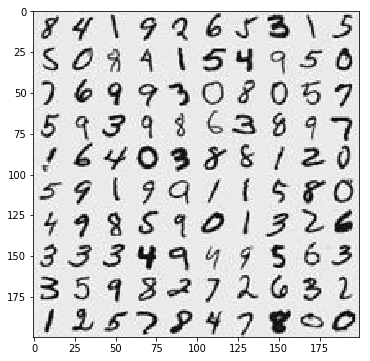

In [4]:
displayImgs()

### Vectorizing Logistic Regression

In [5]:
def hypothesis(theta, X):
    return expit(np.dot(X,theta))

def ComputeCost(theta, X, y, mylambda = 0.):
    m = X.shape[0]
    h = hypothesis(theta , X)
    term1 = np.log(h).dot(-y.T)
    term2 = np.log(1.0 - h).dot(1-y.T)
    left_hand = (term1 - term2)/m
    right_hand = theta.T.dot(theta)*mylambda/(2*m)
    return left_hand + right_hand

In [6]:
def costGradient(theta, X, y, mylambda = 0.):
    m = X.shape[0]
    beta = hypothesis(theta,X)-y.T
    reg_term = theta[1:]*(mylambda/m)
    grad = (1./m)*np.dot(X.T, beta)
    grad[1:] = grad[1:] + reg_term
    return grad

In [7]:
from scipy import optimize


def optimizeTheta(theta,X,y,mylambda=0.):
    result = optimize.fmin_cg(ComputeCost, fprime=costGradient, x0=theta, 
    args=(X, y, mylambda), maxiter=50, disp=False,
    full_output=True)
    
    return result[0], result[1]
        

In [8]:
def buildTheta():
    mylambda = 0.
    initial_theta = np.zeros((X.shape[1],1)).reshape(-1)
    Theta = np.zeros((10, X.shape[1]))
    for i in range(10):
        iclass = i if i else 10
        print ("Optimizing for handwritten number %d..."%i)
        logic_Y = np.array([1 if x == iclass else 0 for x in y])
        itheta, imincost =optimizeTheta(initial_theta, X, logic_Y, mylambda)
        Theta[i, :] = itheta
    print ("Done!")
    return Theta

In [9]:
Theta = buildTheta()

Optimizing for handwritten number 0...
Optimizing for handwritten number 1...
Optimizing for handwritten number 2...
Optimizing for handwritten number 3...
Optimizing for handwritten number 4...
Optimizing for handwritten number 5...
Optimizing for handwritten number 6...
Optimizing for handwritten number 7...
Optimizing for handwritten number 8...
Optimizing for handwritten number 9...
Done!


In [10]:
def predictOneVSAll(Theta, row):
    # Computes hypothesis and returns predicted integer corresponding to the handwritten image
    classes = [10] + np.array([1,2,3,4,5,6,7,8,9,10])
    hypots = [0]*len(classes)
    #Choose max hypothesis
    for i in range(len(classes)):
        hypots[i] = hypothesis(Theta[i], row)
    return classes[np.argmax(np.array(hypots))]

In [11]:
n_correct, n_total = 0., 0.
incorrect_indices = []
for irow in range(X.shape[0]):
    n_total += 1
    if predictOneVSAll(Theta,X[irow]) == y[irow]: 
        n_correct += 1
    else: incorrect_indices.append(irow)

C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


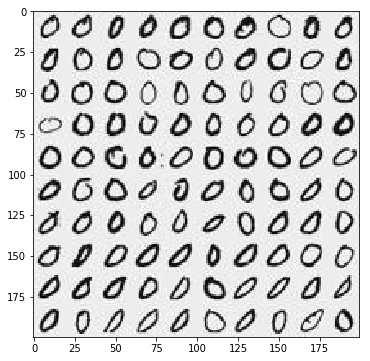

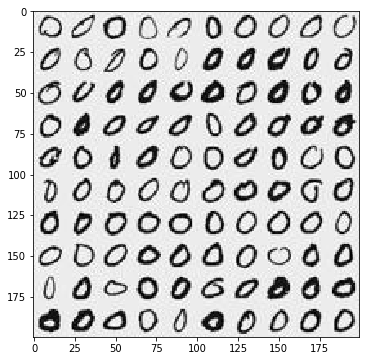

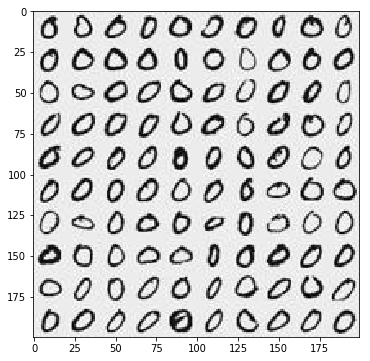

In [12]:
displayImgs(incorrect_indices[:100])
displayImgs(incorrect_indices[100:200])
displayImgs(incorrect_indices[200:300])

### Neural Networks

In [13]:
data_file = os.getcwd() + '\ex3weights.mat'
mat = scipy.io.loadmat(data_file)
Theta1, Theta2 = mat['Theta1'], mat['Theta2']
print ("Theta1 has shape:" ,Theta1.shape)
print ("Theta2 has shape:" ,Theta2.shape)

Theta1 has shape: (25, 401)
Theta2 has shape: (10, 26)


In [14]:
def propagateForward(row, Thetas):
    features = row
    for i in range(len(Thetas)):
        Theta = Thetas[i]
        z = Theta.dot(features)
        a = expit(z)
        if i == len(Thetas)-1:
            return a
        a = np.insert(a,0,1)
        features = a
def predictNN(row, Thetas):
    classes = np.array([1,2,3,4,5,6,7,8,9,10])+[10]
    output = propagateForward(row, Thetas)
    return classes[np.argmax(np.array(output))]

In [15]:
myThetas = [Theta1, Theta2]
n_correct, n_total = 0., 0
incorrect_indices = []
for irow in range(X.shape[0]):
    n_total+=1
    if predictNN(X[irow], myThetas) == int(y[irow]):
        n_correct+=1
    else:
        incorrect_indices.append(irow)


C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  after removing the cwd from sys.path.


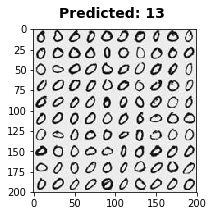

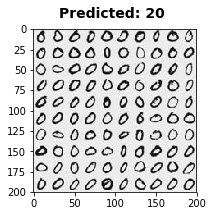

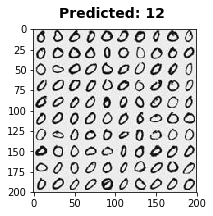

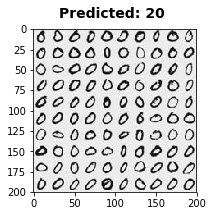

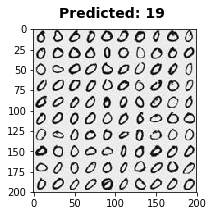

In [19]:
for i in range(5):
    i = random.choice(incorrect_indices)
    fig = plt.figure(figsize=(3,3))
    scipy.misc.imsave('handwritten-predicted.jpg', organizeImgs(X[i]))
    img = mpimg.imread('handwritten.jpg')
    plt.imshow(img,cmap = plt.cm.binary, filternorm=10)
    predicted_val = predictNN(X[i],myThetas)
    predicted_val = 0 if predicted_val == 10 else predicted_val
    fig.suptitle('Predicted: %d'%predicted_val, fontsize=14, fontweight='bold')

At this point, I don't know what happened. Not sure why it reads all the indices as 0.